In [669]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAGothic'

In [583]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

with open("../dump/noun_list.pickle", 'br') as f:
    noun_list = pickle.load(f)

with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)
    
clue_word_entropy = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

In [584]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train = train.loc[train.sentence.str.contains("|".join(clue_word_by_BS))].reset_index(drop=True)
print("train length (filtering) :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train length : 6671
label 1 : 1514 	label 0 : 5157
train length (filtering) : 4386
label 1 : 1206 	label 0 : 3180


In [670]:
# 文中に各手がかり語が含まれているどうかの特徴量を作成

feature_word_dict = {}

for word in np.append(clue_word_entropy, ['用途', '用い', '使わ']):
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [671]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word_entropy, ['用途']))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

In [672]:
# 文中にカテゴリ名が含まれているどうか

category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

In [673]:
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_contain_cat = is_contain_cat
)
train_X.heading_cat = train_X.heading_cat.astype('category') 
train_y = train.label.tolist()

In [674]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.6301469445985631
precision:  0.6929705928934766
recall:  0.581235211412503


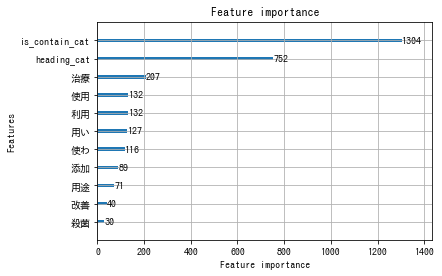

In [662]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [663]:
predict = model.predict(train_X)

In [664]:
TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

In [665]:
print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  692
TN:  2919
FP:  261
FN:  514


In [667]:
print(train.loc[FP_index, 'sentence'].values)

['” スリランカ 韓国 ― PharmAsia News が2009年に報じた処に拠ると、 “OTC鎮痛剤の安全性に関する社会的関心の高まりに充分に対応できていない事から、食品医薬品安全庁はバイエル社のサリドンA等、計28品目を15歳未満の小児に用いることを禁止した。'
 '市販品には、重合禁止剤としてメキノールなどが添加される。'
 '2015年11月、優先審査保証（英語版）の後、米国FDAはオシメルチニブをEGFRチロシンキナーゼ阻害薬治療後に増悪したを転移性EGFRT790M（英語版） 変異陽性非小細胞肺癌（NSCLC）の治療薬として迅速承認（英語版）した。'
 'オシメルチニブは第一選択治療薬としての早期臨床試験の段階にある。'
 'なお、カフェインの排除能力の低いヒトの胎児では、CYP1A2による酸化とは全く別に、メチル化するという代謝経路も利用されることが知られている。'
 '金沢大学医学部整形外科では、独自に開発したカフェイン併用療法を抗がん剤治療の術前に用いて、骨肉腫や軟部腫瘍の治療に効果を上げたとして、厚生労働省から高度先進医療として承認されていたが、2010年に同療法を実施されていた患者の一人が死亡するという事態が発生し、さらに「臨床研究に関する倫理指針」違反などの疑いがあることが発覚、有効性と安全性に関する評価が確立されていない治療法であることがあらためて確認されたことから、先進医療から削除された。'
 '芳香族化合物である安息香酸ナトリウムカフェインは、清涼飲料等の保存料のほか、単体と同じく強心・興奮作用を期待して使われる。'
 '一部ではウイルス量が多い場合やCD4数が少ない場合の初期治療にネビラピンを用いる事に懸念が示されているが、これらの患者でもネビラピンが有効であるとの報告も有る。'
 '液体側（酸化剤）としては、亜酸化窒素（笑気とも呼ばれる）を用いたものがSpaceDev（英語版）社が開発したスペースシップツーなどで、地上での最高速度記録を目指して開発中の Bloodhound SSC やシエラ・ネヴァダ社が開発中の有人宇宙船ドリームチェイサーなどでは高濃度過酸化水素を用いている。'
 '同様の推進剤が APCP（過塩素酸アンモニウムコンポジット推進薬）と呼ばれてより大型のロケットでも利用されている。'
 'HTPB を用いたポリ